In [1]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 21.4 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

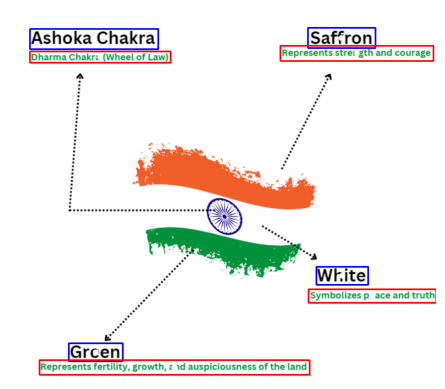

True

In [2]:
import cv2
import easyocr
import matplotlib.pyplot as plt

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Load the image
image_path = 'sample.png'  # Make sure to upload your image to the Colab environment
image = cv2.imread(image_path)

# Perform OCR
results = reader.readtext(image)

# Create a copy of the image for marking
marked_image = image.copy()

# Store text data and their bounding boxes
text_boxes = []

# Process each detected text
for (bbox, text, prob) in results:
    # Get the bounding box coordinates
    top_left = (int(bbox[0][0]), int(bbox[0][1]))
    bottom_right = (int(bbox[2][0]), int(bbox[2][1]))

    # Calculate the color of the text region
    text_region = image[int(bbox[0][1]):int(bbox[2][1]), int(bbox[0][0]):int(bbox[2][0])]
    avg_color = cv2.mean(text_region)[:3]

    # Determine the color to mark based on average color
    if avg_color[0] > avg_color[1] and avg_color[0] > avg_color[2]:
        mark_color = (0, 255, 0)  # Green for predominantly red text
        color_name = "red"
    elif avg_color[1] > avg_color[0] and avg_color[1] > avg_color[2]:
        mark_color = (0, 0, 255)  # Blue for predominantly green text
        color_name = "green"
    else:
        mark_color = (255, 0, 0)  # Red for predominantly blue text
        color_name = "blue"

    # Draw the bounding box with the determined color
    cv2.rectangle(marked_image, top_left, bottom_right, mark_color, 2)

    # Calculate the center of the bounding box
    center_x = int((top_left[0] + bottom_right[0]) / 2)
    center_y = int((top_left[1] + bottom_right[1]) / 2)
    center = (center_x, center_y)

    # Draw a circle at the center
    cv2.circle(marked_image, center, 5, (255, 255, 255), -1)  # White circle

    # Store the text and its bounding box
    text_boxes.append({
        "text": text,
        "bbox": (top_left, bottom_right),
        "color": color_name,
        "center": center
    })

# Save or display the marked image
plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Save marked image for later use
cv2.imwrite('marked_image.png', marked_image)


In [3]:
import numpy as np
import json

# Assume text_boxes is already populated from the first part of your code

# Count occurrences of each color
color_count = {}
for box in text_boxes:
    color = box["color"]
    color_count[color] = color_count.get(color, 0) + 1

# Determine the heading color
heading_color = min(color_count.items(), key=lambda x: (x[1], list(color_count.keys()).index(x[0])))[0]

# Gather elements by color
color_elements = {color: [] for color in color_count}
for box in text_boxes:
    color_elements[box["color"]].append(box["text"])

# Calculate distances and map elements
mappings = {}
heading_centers = [box["center"] for box in text_boxes if box["color"] == heading_color]
other_colors = [color for color in color_elements.keys() if color != heading_color]

for heading_text, heading_center in zip(color_elements[heading_color], heading_centers):
    nearest_mapping = []
    for other_color in other_colors:
        for other_text, other_center in zip(color_elements[other_color], [box["center"] for box in text_boxes if box["color"] == other_color]):
            distance = np.linalg.norm(np.array(heading_center) - np.array(other_center))
            # Define a threshold for "closeness"
            if distance < 200:  # Adjust the threshold as needed
                nearest_mapping.append(other_text)

    if nearest_mapping:
        mappings[heading_text] = nearest_mapping

# Prepare output without nesting
output_data = {heading_text: nearest_mapping for heading_text, nearest_mapping in mappings.items()}

# Save to JSON file
with open('output_mappings.json', 'w') as json_file:
    json.dump(output_data, json_file, indent=4)

# Display results
print(output_data)
print("Output saved to 'output_mappings.json'")


{'Ashoka Chakra': ['Dharma Chakra (Wheel of Law)'], 'Saffron': ['Represents strength and courage'], 'White': ['Symbolizes peace and truth'], 'Green': ['Represents fertility, growth; and auspiciousness of the land']}
Output saved to 'output_mappings.json'
